In [1]:
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('..')
from IPython.display import clear_output
from scipy.linalg import sqrtm
from lib import simulator

In [2]:
rho = np.array([[1., 0.], [0., 0.]]) # target state
dim = rho.shape[0]

projectors_cnt = 10
measurements_cnt = 100

train_size = projectors_cnt * measurements_cnt
train_X, train_y = simulator.generate_dataset(rho, projectors_cnt, measurements_cnt)
train_y = train_y.astype('float64')

In [3]:
sess = tf.InteractiveSession()

M_real, M_img = tf.Variable(tf.random_normal([dim, dim])), tf.Variable(tf.random_normal([dim, dim]))
M = tf.complex(M_real, M_img)

rho_ph = tf.placeholder(dtype=M.dtype, shape=[dim, dim])
x_ph = tf.placeholder(dtype=M.dtype, shape=[None, dim, dim])
y_ph = tf.placeholder(dtype=tf.float32, shape=[None])

sigma = tf.matmul(tf.conj(M), M, transpose_a=True)
sigma /= tf.trace(sigma)

measurements = tf.real(tf.trace(tf.einsum('bij,jk->bik', x_ph, rho_ph)))
prediction = tf.real(tf.trace(tf.einsum('bij,jk->bik', x_ph, sigma)))
loss = tf.losses.mean_squared_error(prediction, y_ph)

update_M = tf.train.GradientDescentOptimizer(learning_rate=1e-1).minimize(loss, var_list=[M_real, M_img])
sess.run(tf.global_variables_initializer())

W0831 09:22:45.001593 139825193596672 deprecation.py:323] From /mnt/spopov/miniconda3/envs/dl/lib/python3.7/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
epoches = int(5e3)
loss_history = []
metrics_history = []
measurements_rho = sess.run(measurements, {x_ph: train_X, rho_ph: rho})

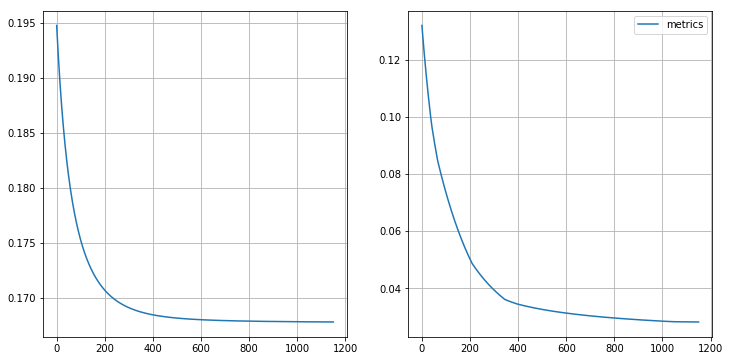

Epoch: 1150, Loss: 0.16777805984020233, Metrics: 0.028246723115444183


In [5]:
for t in range(epoches):
    loss_t, _ = sess.run([loss, update_M], {x_ph: train_X, y_ph: train_y})
    loss_history.append(loss_t)
    
    sigma_pred = sess.run(sigma)
    measurements_sigma = sess.run(measurements, {x_ph: train_X, rho_ph: sigma_pred})
    
    diff = abs(measurements_sigma - measurements_rho)
    metrics_history.append(diff.mean())
    
    if t > 0 and abs(loss_history[-1] - loss_history[-2]) < 1e-7:
        break
    
    if t % 50 == 0:
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(1, 2, 2)
        plt.plot(metrics_history, label='metrics')
        plt.legend()
        plt.grid()
        plt.show()
        print(f'Epoch: {t}, Loss: {loss_t}, Metrics: {metrics_history[-1]}')

In [6]:
sigma_pred = sess.run(sigma)
sigma_pred

array([[ 0.97273886+1.7107883e-10j, -0.02010348-3.3740059e-02j],
       [-0.02010349+3.3740059e-02j,  0.02726113-1.7107882e-10j]],
      dtype=complex64)

In [7]:
def tf_fidelity(state_1, state_2):
    state_1_sqrt = tf.linalg.sqrtm(state_1)
    F = tf.matmul(tf.matmul(state_1_sqrt, state_2), state_1_sqrt)
    return tf.real(tf.trace(tf.linalg.sqrtm(F)) ** 2)

In [8]:
fidelity = tf_fidelity(rho.astype(np.complex64), sigma_pred)
sess.run(fidelity)

0.97273886